# Miary jakości modelu

W tym ćwiczeniu skorzystamy z modułu sklearn [scikit-learn](https://scikit-learn.org/stable/auto_examples/index.html) przeznaczonego do uczenia maszynowego. Zawiera wiele zoptymalizowanych i przydatnych funkcji i algorytmów. Alternatywnymi frameworkami są np. [PyTorch](https://pytorch.org/tutorials/), [Tensorflow](https://www.tensorflow.org/tutorials), [Keras](https://keras.io/examples/), [Caffe2](https://caffe2.ai/docs/tutorials), chociaż z obserwacji środowiska wynika, że dominują raczej PyTorch i Tensorflow.


Na stronie przedmiotu znajduje się instrukcja konfiguracji środowiska w przypadku pracy lokalnej, a nie w colabie. Może (nie musi) być przydatna dla osób pracujących na własnych laptopach:

https://brain.fuw.edu.pl/edu/index.php/Uczenie_maszynowe_i_sztuczne_sieci_neuronowe/konfiguracja

### Przygotowanie środowiska programistycznego

In [1]:
import sklearn
print('Zainstalowana wersja scikit-learn: {}.'.format(sklearn.__version__))

import numpy as np
from scipy import diag, interp
from itertools import cycle

from sklearn.model_selection import StratifiedKFold, train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression

from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import make_scorer

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd

Zainstalowana wersja scikit-learn: 1.1.1.


# Walidacja krzyżowa
Już na ostatnich ćwiczeniach przerobiliśmy walidację krzyżową (ang. cross validation). Teraz przyjrzymy się jej bliżej i sprawdźmy efekt wspomniany na wykładzie, czyli efekt częstości występowania.

* W tym ćwiczeniu przyjrzymy się jak miary jakości klasyfikatora zależą od proporcji klas w zbiorze uczącym i od rozmiaru zbioru uczącego
* Klasyfikatorem będzie nadal regresja logistyczna, ale tym razem zamiast korzystać z własnej implementacji, skorzystamy z gotowej wersji bibliotecznej z modułu [scikit-learn] (http://scikit-learn.org/stable/index.html)


### Przygotowanie syntetycznych danych

Nasze przykłady będą należały do dwu klas: **0** lub **1**. Wartości zmiennych wejściowych $(x, y)$ dla danej klasy są dane dwuwymiarowym rozkładem Gaussa:

$$
p_{class~1}(x,y) = N(\mu_{class~1, x}, \mu_{class~1, y}, \text{covariance})
$$

**Proszę:** 

* uzupełnić kod funkcji ```generate_class_points(nPoints, means, covariances, class)``` która zwraca macierz $(nPoints, 3)$ zawierającą położenia punktów danej klasy, oraz jej numer: (x,y,class) funkcja na wejściu przyjmuje:


    * liczbę przykładów do generacji $nPoints$, macierze $means$ i $covariance$ zawierające średnie i kowariancę dla danej klasy:

$$
means = [\mu_{x}, \mu_{y}]
$$

$$
covariance = 
\begin{bmatrix}
    \sigma^{2}_{x} & \sigma_{xy} \\
    \sigma_{xy} & \sigma^{2}_{y}
\end{bmatrix}   
$$

    * liczbę kodującą numer klasy : $class$, w naszym przypadku 0 lub 1
 
 
**Proszę:**

używając z funkcji  ```generate_class_points(nPoints, means, covariances)``` wygenenerować po 10000 punktów dla dwu klas, dla których parametry rozkładów Gaussa są następujące:

```Python
means_class_0 = np.array([-1,0.5]) 
covariance_class_0 = np.diag([3,3]) 

means_class_1 = np.array([1.2,4]) 
covariance_class_1 = np.diag([4, 1.7]) 
```

Dane proszę załadować do obiektów pandas DataFrame dla każdej z klas, a następnie je połączyć korzystając z funkcji ```pandas.concatenate()```.

In [2]:
def generate_class_data(nPoints, means, covariances, label):
    #Generacja własności - w naszym wypadku wartości (x,y) dla danej klasy
    #BEGIN_SOLUTION
    features = np.random.multivariate_normal(means,covariances,nPoints)
    #END_SOLUTION
    #Generacja macierzy z etykietami - tutaj numerem klasy
    labels = np.full((nPoints,1), label)
    #Połączenie macierzy dla własności i etykiet w jedną macierz
    class_data = np.concatenate((features, labels), axis=1)
    return class_data
    
nPoints = 10000    
    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
#BEGIN_SOLUTION
means_class_0 = np.array([-1,0.5]) 
covariance_class_0 = np.diag([3,3]) 
#END_SOLUTION

#Definicja parametrów rozkładu Gaussa dla klasy "1"
#BEGIN_SOLUTION
means_class_1 = np.array([1.2,4]) 
covariance_class_1 = np.diag([4, 1.7]) 
#END_SOLUTION

#Generacja danych dla klas "0" i "1"
#BEGIN_SOLUTION
class_0_data = generate_class_data(nPoints, means_class_0, covariance_class_0, label=0)
class_1_data = generate_class_data(nPoints, means_class_1, covariance_class_1, label=1)
#END_SOLUTION

#Sprawdzenie czy wygenerowane dane mają poprawny kształt
print("class_0_data.shape ",class_0_data.shape)
print("class_1_data.shape ",class_1_data.shape)

#Utworzenie obiektu DataFrame dla klas "0" i "1"
#BEGIN_SOLUTION
df_class_0 = pd.DataFrame(data=class_0_data, columns = ["x", "y", "label"])
df_class_1 = pd.DataFrame(data=class_1_data, columns = ["x", "y", "label"])
#END_SOLUTION

#Utworzenie obiektu DataFrame dla odu klas lącznie
df = pd.concat([df_class_0, df_class_1], ignore_index=True)

#Wypisanie zawartości obiektu DataFrame dla odu klas lącznie
print(df)

class_0_data.shape  (10000, 3)
class_1_data.shape  (10000, 3)
              x         y  label
0     -0.677731  0.552629    0.0
1     -2.821246  2.844540    0.0
2     -0.737389 -1.700049    0.0
3      1.430541  1.751377    0.0
4     -1.228342  2.158746    0.0
...         ...       ...    ...
19995  0.003325  5.481831    1.0
19996  0.511613  5.006285    1.0
19997  0.061549  2.833663    1.0
19998  1.515413  5.558962    1.0
19999  5.110123  4.439844    1.0

[20000 rows x 3 columns]


## Analiza wizualna danych. 

Pierwszy krok przy analizie danych z użyciem dowolnego algorytmu to ich inspekcja. Korzystając z metod klasy DataFrame proszę:
* narysować rozkłady wszystkich zmiennych wejściowych oddzielnie dla klas 0 i 1
* narysować wykres korelacji między zmiennymi wejściowymi dla klas 0 i 1 na jednym rysunku

**Wskazówka**: proszę użyć parametru "hue" funkcji ```sns.jointplot()```

Oglądając rysunki proszę sprawdzić jakościowo czy:
* czy średnie wartości $x$ i $y$ są zgodne z założeniami? 
* czy krotność klas jest zgodna z założeniami?
* czy rozkłady dwuwymiarowe są zgodne z założeniem diagonalnej macierzy kowiariancji? 

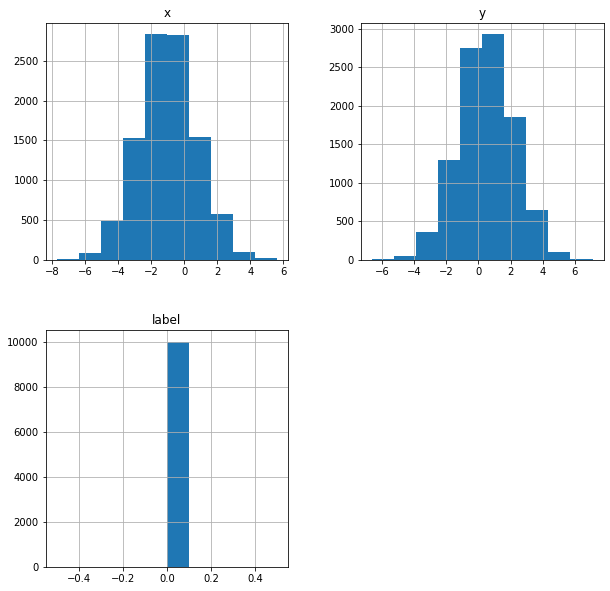

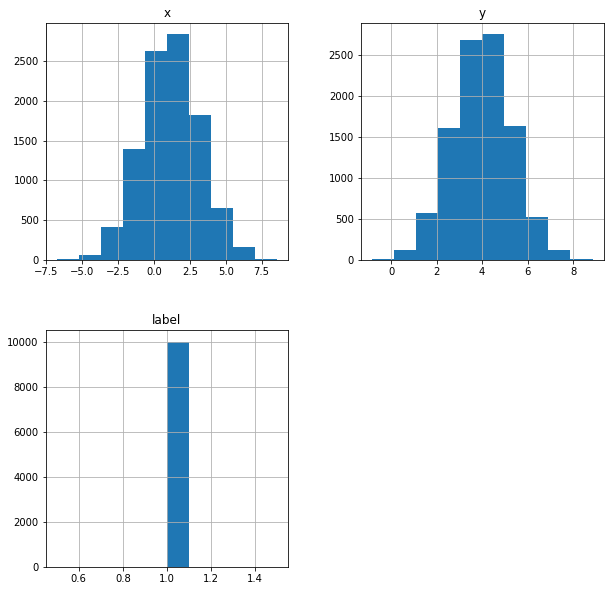

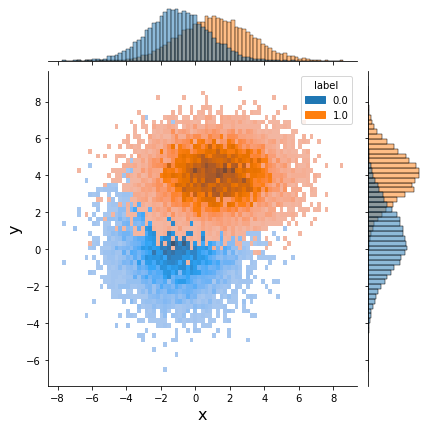

In [3]:
#Histogramy rozkładów dla klasy "0"
#BEGIN_SOLUTION
df_class_0.hist(figsize=(10,10))
#END_SOLUTION

#Histogramy rozkładów dla klasy "1"
#BEGIN_SOLUTION
df_class_1.hist(figsize=(10,10))
#END_SOLUTION

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1"
#BEGIN_SOLUTION
x = sns.jointplot(x="x", y="y", data=df, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);
#END_SOLUTION
##

# Przypadek klas równolicznych

* podziel pełne dane na podzbiory uczący (80% danych) i terningowy (20% danych). Wykonując podział zwróć uwagę na randomizację danych.
* narysuj dwuwymiarowe rozkłady dla zbiorów uczącego i treningowego i sprawdź wizulanie czy są różne. 

**Wskazówka:** do podziałów zbioru proszę użyć funkcji [train_test_split](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) podając obiekt DataFrame jako argument.

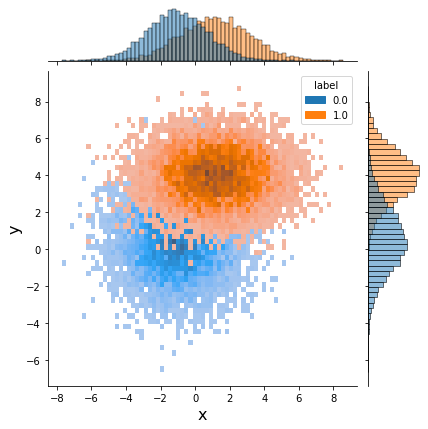

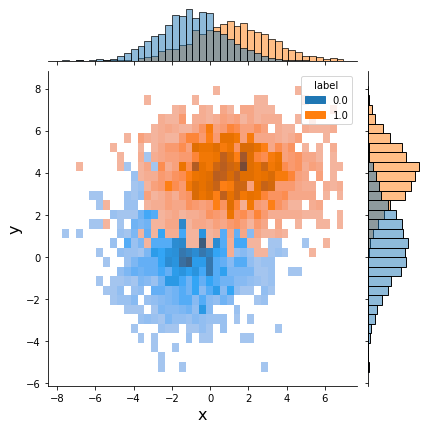

In [4]:
#Podział danych na zbiory uczący i testowy
#BEGIN_SOLUTION
df_train, df_test = train_test_split(df, test_size=0.2)
#END_SOLUTION

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1" dla zbioru uczącego
x = sns.jointplot(x="x", y="y", data=df_train, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1" dla zbioru testowego
x = sns.jointplot(x="x", y="y", data=df_test, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);

## Trening regresji logistycznej

Skorzystamy z implementacji regresji logistycznej z pakietu scikit-learn.
Regresja logistyczna zaimplementowana jest w klasie [`LogisticRegression`](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html). 

**Proszę:**

* stworzyć obiekt klasy ```LogisticRegression()```
* użyć tego obiektu by wytrenować model. W tym miejscu wykonają się kroki odpowiadające procedurze minimalizacji znajdującej parametry $\theta$ z zajęciach o regresji logistycznej
* przeprowadzić predykcję na zbiorze testowym

**Wskazówka** domyślną funkcją minimalizacji jest 'lbfgs', ale warto ją podać explicite by uniknąć uciążliwego ostrzeżenia.

In [5]:
#Definicja modelu - obiektu klasy LogisticRegression
#BEGIN_SOLUTION
model = LogisticRegression(solver = 'lbfgs')
#END_SOLUTION

#Przeprowadzenie minmalizacji, inaczej dopasowania, parametrów modelu (ang. fit) trenowania modelu
#BEGIN_SOLUTION
model.fit(df_train[["x","y"]], df_train["label"]);
#END_SOLUTION

#Przeprowadzenie predykcji (ang. predict)
y_pred = model.predict(df_test[["x","y"]])  

**Proszę**

* obliczyć i narysować macierz pomyłek (ang. confusion matrix)

**Wsakzówki:**
* skorzystaj z funkcji ```metrics.confusion_matrix()``` by wypisać wartości macierzy
* skorzystaj z funkcji ```ConfusionMatrixDisplay.from_estimator()``` by narysować macierz pomyłek
* skorzystaj z funkcji ```onfusionMatrixDisplay.from_estimator()``` z odpowiednim parameterem, by narysować macierz pomyłek z wartościami znormalizowanymi względem liczby przykładów w prawdziwych klasach

**Pytanie**: jaką iterpretację mają elementy macierzy po normalizacji?

[[1843  227]
 [ 160 1770]]


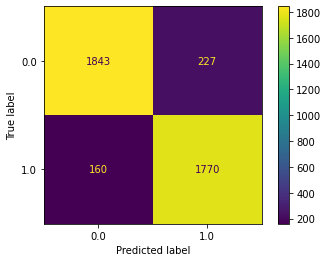

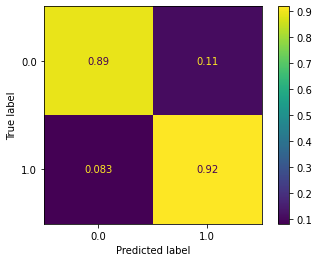

In [6]:
#Obliczenie macierzy pomyłek
cm = confusion_matrix(df_test["label"], y_pred)
#Wypisanie macierzy pomyłek w postaci tekstowej
#BEGIN_SOLUTION
print(cm)
#END_SOLUTION

#Narysowanie macierzy pomyłek. 
#BEGIN_SOLUTION
ConfusionMatrixDisplay.from_estimator(model, df_test[["x","y"]], df_test["label"])
#END_SOLUTION

#Narysowanie macierzy pomyłek z normalizacją względem liczny przykładów w prawdziwych przykładów.
#BEGIN_SOLUTION
#metrics.plot_confusion_matrix(model, df_test[["x","y"]], df_test["label"], normalize="true"); 
ConfusionMatrixDisplay.from_estimator(model, df_test[["x","y"]], df_test["label"],normalize="true");
#END_SOLUTION
##

Zbadajmy wartości różnych miar jakości:

* **precyzja pozytywna (positive predictive value (PPV), precision):**

$\qquad$ $PPV = \frac{TP}{P'}=\frac{TP}{ TP + FP}$

Ułamek przypadków oznaczonych jako klasa "1" który naprawdę należy do klasy "1". Ułamek ten jest np. odpowiedzą na pytanie
"Jeśli wynik testu jest pozytywny, jakie jest prawdopodobieństwo, że osoba badana jest chora?"

* **czułość: (ang. True Positive Rate, TPR, or recall):** 

$\qquad$ $TPR = \frac{TP}{ P} = \frac{TP} { TP+FN}$

Ułamek przypadków które należą do klasy "1" i został poprawnie oznaczony. Ułamek ten jest np. odpowiedzą na pytanie  "Jakie jest prawdopodobieństwo, że test wykonany dla osoby chorej wykaże, że jest ona chora?"


* **dokładność ( accuracy (ACC)):** Prawdopodobieństwo prawidłowej klasyfikacji.

$\qquad$ $ACC = \frac{TP + TN}{P + N}$

Ułamek przypadków, niezależnie od klasy, które zostały poprawnie oznaczone. Ułamek ten jest np. odpowiedzą na pytanie  "Jakie jest prawdopodobieństwo, że test poda poprawną odpowiedź?" 

* **F1-score:** średnia harmoniczna z precyzji i czułości:

$\qquad$ $F_1= 2 \frac{PPV  \cdot TPR}{PPV+TPR}= \frac{2TP}{ 2TP+FP+FN}$

Miara ta daje ocenę balansu między czułością a precyzją. Miara ta nie uwzględnia wyników prawdziwie negatywnych.

* **współczynnik korelacji Matthewsa ( Matthews correlation coefficient):**

$\qquad$ $
\text{MCC} = \frac{ TP \cdot TN - FP \cdot FN } {\sqrt{ (TP + FP) ( TP + FN ) ( TN + FP ) ( TN + FN ) } }
$

Współczynnik MMC uwzględnia wyniki zarówno prawdziwie jaki i fałszywie pozytywne i negatywne i jest na ogół uważany jako zrównoważona miara, która może być stosowana nawet wtedy, gdy klasy są bardzo różnej liczebności. 

MCC jest w istocie współczynnikiem korelacji pomiędzy obserwowanymi i przewidywanymi klasyfikacjami binarnymi; zwraca wartość od -1 do +1. 

* Współczynnik +1 odpowiada idealnej klasyfikacji, 
* 0 nie lepiej niż losowe przypisanie wyniku i 
* -1 oznacza całkowitą niezgodę między klasyfikacją  i stanem faktycznym.
 
***
 
**Proszę** 

uzupełnić funkcję ```calculate_metric(data, nIter)```, która:
* liczy powyższe wskaźniki powtarzając podziały próbki na fragmenty uczący i testowy $nIter$ razy (za każdym razem losując od nowa)
* zwraca macierz wartości miar, gdzie dla każdego wiersza mamy następujące znaczenie kolumn: $(PPV, TPR, ACC, F1, MCC)$. Macierz powinna więc mieć kształ (nIter, 5)
* korzystając z funkcji ```calculate_metric(data, nIter)``` proszę:
    * obliczyć wartości parametrów dla 100 iteracji
    * stworzyć obiekt DataFrame zawierający kolumny "PPV", "TPR", "ACC", "F1", "MCC"
    * narysować rozkłady wartości miar jakości
    * narysować rozkłady dokładności (ACC) jako dane podając oryginalną próbkę oraz próbkę stanowiącą 10% oryginalnej

CPU times: user 9.73 s, sys: 34.4 s, total: 44.1 s
Wall time: 3.6 s


<AxesSubplot:>

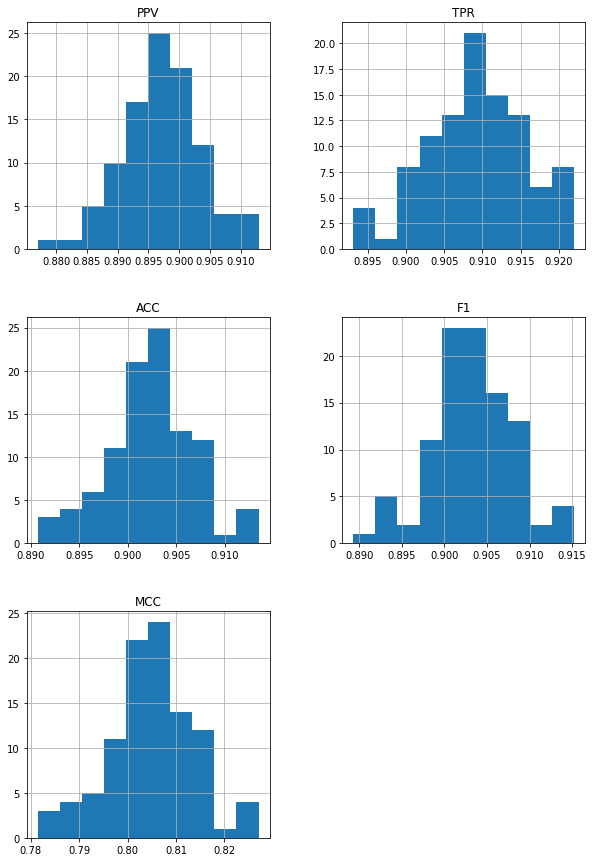

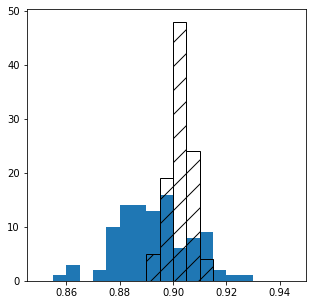

In [7]:
%%time
def calculate_metric(data, nIter):
    model = LogisticRegression(solver = 'lbfgs') 
    result = np.array([])
    #Pętla po kolejnych iteracjach procesu trenowania-testowania
    for i in range(nIter):
        #Podział próbki na części treningową i testową
        #BEGIN_SOLUTION
        df_train, df_test = train_test_split(data, test_size=0.2, shuffle=True)
        #END_SOLUTION
        #znajdowanie parametrów modeli
        #BEGIN_SOLUTION
        model.fit(df_train[["x","y"]], df_train["label"]);
        #END_SOLUTION
        #Predykcja
        #BEGIN_SOLUTION
        y_pred = model.predict(df_test[["x","y"]]) 
        y_true = df_test["label"]
        #END_SOLUTION
        #Obliczenie wartości miar jakości
        PPV = metrics.precision_score(y_true, y_pred)
        TPR = metrics.recall_score(y_true, y_pred)
        ACC = metrics.accuracy_score(y_true, y_pred)
        F1 = metrics.f1_score(y_true, y_pred)
        MCC = metrics.matthews_corrcoef(y_true, y_pred)
        #Spakowanie uzyskanych licz do jednej macierzy
        result = np.append(result, np.array([PPV, TPR, ACC, F1, MCC]), axis=0)
        
    result = np.reshape(result, (-1,5))    
    return result     
  
#Obliczenie wartości metryk na pełnych danych    
metrics_data = calculate_metric(df, nIter=100)
#Przepakowanie uzyskanych liczb do obiektu DataFrame
df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
#Wyrysowanie histogramów dla wszystkich metryk
df_metrics.hist(figsize=(10,15));


#Obliczenie wartości metryk na 10% danych  
#BEGIN_SOLUTION
metrics_data = calculate_metric(df.sample(frac=0.1), nIter=100) 
df_metrics_10percent = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
#END_SOLUTION

#Wyrysowanie rozkładu dokładności (ACC) dla obu zestawów danych 
axis = plt.figure(figsize=(5,5)).subplots(1, 1);
df_metrics_10percent["ACC"].hist(ax = axis, bins=np.arange(0.85, 0.95, 0.005), grid=False);
df_metrics["ACC"].hist(ax=axis,  bins=np.arange(0.85, 0.95, 0.005), fill=False, hatch="/", grid=False);

Jaka jest zależność rozrzutu wyniku metryki od rozmiaru próbki?

Proszę postawić jakąś hipotezę, a potem uruchomić poniższą komórkę. 
* Czy wykresy z tej komórki zgadzają się z hipotezą?
* Co w ogóle jest obliczane w tej komórce?

**Uwaga:** wykonanie kodu może zająć kilka minut.

CPU times: user 48.9 s, sys: 2min 37s, total: 3min 26s
Wall time: 21.7 s


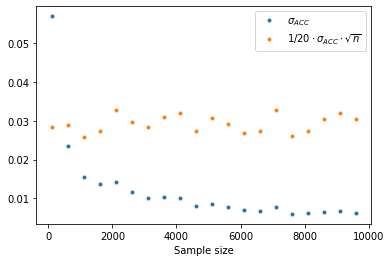

In [8]:
%%time
def evaluate_std(nEvents, nIter):
    metrics_data = calculate_metric(df.sample(nEvents), nIter=nIter) 
    df_metrics = pd.DataFrame(data=metrics_data, columns = ["PPV", "TPR", "ACC", "F1", "MCC"])
    return df_metrics["ACC"].std()

nIter = 100
sampleSizes = np.arange(100,10000,500)
std_values = [evaluate_std(nEvents, nIter) for nEvents in sampleSizes]

plt.plot(sampleSizes, std_values, ".", label = r"$\sigma_{ACC}$")
plt.plot(sampleSizes, std_values*np.sqrt(sampleSizes)/20, ".", label=r"$1/20 \cdot \sigma_{ACC} \cdot \sqrt{n}$")
plt.xlabel("Sample size")
plt.legend();

W czasie analizy wydajności modelu zwykle stosuje się modyfikację losowego podziału na dane treningowe i testowe. Całe dane są dzielone na
równych ```k``` podziałów (ang. folds) i jest przeprowadzana k-krotna procedura sprawdzania (ang. k-fold cross-validation, pl. walidacja krzyżowa):

0. dzielimy zbiór uczący (features, labels) na `k` równych części
1. odkładamy i-tą, i=(0,1,2,3,...,k-1), część jako dane testowe, 
2. na pozostałych `k-1` częściach uczymy klasyfikator
3. obliczamy miary jakości na tej odłożonej części
4. wracamy do punktu 1
5. na końcu mozna policzyć wartości metryk uśrednione po podziałach

Procedura sprawdzania metryk z użyciem "k-fold cross-validation" jest zaimplementowana w pakiecie `sklearn` przez funkcję [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

Funkcja ```print_k_cv_scores(data, model)``` wypisuje na ekran wartości metryk obliczone z użyciem walidacji krzyżowej. Funkcja przyjmuje na wejściu:
* obiekt DataFrame reprezentujący dane
* model z pakietu  `sklearn` reprezentujący model do wytrenowania (w naszym przypadku `LogisticRegression`)

**Proszę:**

* uzupełnić funkcję 'cross_val_score' by wypisywała wartości dla metryk ```['precision','recall','accuracy','f1', 'matthews_corrcoef']```

In [9]:
#Dodajemy metrykę MCC do listy fukncji oceniających
#metrics.SCORERS['matthews_corrcoef'] = make_scorer(metrics.matthews_corrcoef)

def print_k_cv_scores(data, model):
    #Lista z nazwami metryk rozpoznawanymi przez funkcję cross_val_score
    #BEGIN_SOLUTION
    metric_names = ['precision','recall','accuracy','f1','matthews_corrcoef']
    #END_SOLUTION
    #Pętla po metrykach do policzenia
    for metric_name in metric_names:
        #Obliczenie wartości metryki
        value = cross_val_score(model, data[["x","y"]], data["label"], cv=5, scoring=metric_name)
        print(metric_name.capitalize()+' = {0:.2f} +/- {1:.2f}'.format(value.mean(),value.std()))
        
#Wołamy funkkcję wypisującą wartości metryk        
print_k_cv_scores(data=df, model=LogisticRegression(solver = 'lbfgs')) 

Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.01
Accuracy = 0.90 +/- 0.01
F1 = 0.90 +/- 0.01
Matthews_corrcoef = 0.80 +/- 0.01


Funkcja ```plot_ROC(data, assignAllToClass1)``` dla każdego podziału (ang. fold) oblicza wartości metryk (na zbiorze testowym) dla poszczególnych podziałów i rysuje krzywą ROC. Funkcja przyjmuje na wejściu:
* obiekt DataFrame reprezentujący dane
* parametr ```assignAllToClass1``` pozwalający na przypisanie wszytkich przykładów do klasy "1" (użyteczny w dalszej części ćwiczeń)

**Proszę:**

* uzupełnić funkcję ```plot_ROC(data, assignAllToClass1)```

Fold number: 0
Precision = 0.90 +/- 0.00
Recall = 0.91 +/- 0.02
Accuracy = 0.90 +/- 0.01
F1 = 0.90 +/- 0.01
Matthews_corrcoef = 0.80 +/- 0.01
Fold number: 1
Precision = 0.89 +/- 0.01
Recall = 0.90 +/- 0.01
Accuracy = 0.89 +/- 0.01
F1 = 0.89 +/- 0.01
Matthews_corrcoef = 0.79 +/- 0.02
Fold number: 2
Precision = 0.90 +/- 0.01
Recall = 0.91 +/- 0.01
Accuracy = 0.91 +/- 0.00
F1 = 0.91 +/- 0.00
Matthews_corrcoef = 0.81 +/- 0.01
Fold number: 3
Precision = 0.89 +/- 0.01
Recall = 0.91 +/- 0.01
Accuracy = 0.90 +/- 0.00
F1 = 0.90 +/- 0.01
Matthews_corrcoef = 0.80 +/- 0.01
Fold number: 4
Precision = 0.91 +/- 0.01
Recall = 0.91 +/- 0.01
Accuracy = 0.91 +/- 0.01
F1 = 0.91 +/- 0.01
Matthews_corrcoef = 0.82 +/- 0.02


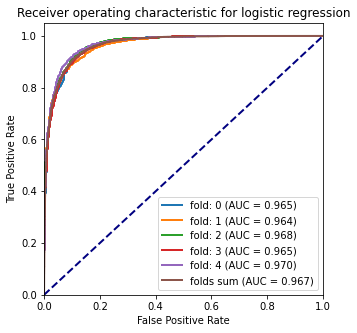

In [10]:
from termcolor import colored

def plot_ROC(data, assignAllToClass1 = False):
    #Tworzymy obiekt wykonujący podziały próbki
    skf  = StratifiedKFold(n_splits=5)
    #Definiujemy model który będzie optymalizowany
    model = LogisticRegression(solver = 'lbfgs')
    #Przygotowujemy pole do rysowania
    plt.figure(figsize=(5,5))
    #Licznik podziałów
    foldNumber=0
    #Macierze przechowujące wyniki dla poszczególnych podziałóww
    y_pred_sum = np.array([])
    y_true_sum = np.array([])

    for train_indices, test_indices in skf.split(data, data["label"]):
        #Tworzymy zbiory uczący i testowy
        df_train = data.reindex(train_indices).dropna()
        df_test = data.reindex(test_indices).dropna()
        #Wykonujemy dopasowanie do zbioru uczącego
        #BEGIN_SOLUTION
        model.fit(df_train[["x","y"]], df_train["label"])
        #END_SOLUTION
        #Wypisujemy wartości metryk dla na zbiorze testowym
        print(colored("Fold number:","red"),foldNumber)
        #BEGIN_SOLUTION
        print_k_cv_scores(df_test, model)
        #END_SOLUTION
        #Obliczamy wynik działania modelu (=prawdopodobieństwo przynależności do klas "0" i "1")
        y_pred = model.predict_proba(df_test[["x","y"]])
        if assignAllToClass1:
            y_pred = np.full_like(y_pred, 1.0) 
        #Wybieramy prawdopodobieństwo przynależności do klasy "1"
        #BEGIN_SOLUTION
        y_pred = y_pred[:,1]
        #END_SOLUTION
        #Dołączamy wyniki dla danego podziału do macierzy przechowujących dane dla wszyskich podziałów
        y_pred_sum = np.append(y_pred_sum, y_pred)
        y_true_sum = np.append(y_true_sum, df_test["label"])
        #Obliczamy dane dla krzywej ROC
        #BEGIN_SOLUTION
        fpr, tpr, thresholds = roc_curve(df_test["label"], y_pred)
        #END_SOLUTION
        #Obliczamy powierzchnię pod krzywą ROC
        #BEGIN_SOLUTION
        roc_auc = auc(fpr, tpr)
        #END_SOLUTION 
        #Rysujemy krzywą ROC
        plt.plot(fpr, tpr, lw=2, label="fold: {:d} (AUC = {:0.3f})".format(foldNumber, roc_auc))
        foldNumber+=1
    #Obliczamy i rysujemy krzywą ROC dla sumy podziałów
    fpr, tpr, thresholds = roc_curve(y_true_sum, y_pred_sum)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, lw=2, label="folds sum (AUC = {:0.3f})".format(roc_auc))
    #Dodajemy krzywą ROC losowego klasyfikatora.
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic for logistic regression')
    plt.legend(loc="lower right")
    plt.show()   
 
#Wołamy funkcję do rysowania. 
plot_ROC(data=df)   

Podobnie jak to było w przypadku losowego podziału możemy sprawdzić jak wyniki zależą od rozmiaru zbioru uczącego. Funkcja ```evaluate_metris_with_cross_validation(nEvents, metric_name)``` tworzy obiekt DataFrame zawierający średnią i odchylenie standardowe metryk obliczone dla podziałów. Proszę przeanalizować rysunki i odpowiedzieć na pytanie:

* która metryka wyróznia się spośród pozostałych?
* jaka jest zależność funkcyjna odchylenia standardowego metryk od rozmiaru próbki? Proszę zmodyfikować kod by zweryfikować swoją hipotezę.
* jaką wadę ma metryka MCC?

CPU times: user 1.3 s, sys: 18 ms, total: 1.32 s
Wall time: 1.31 s


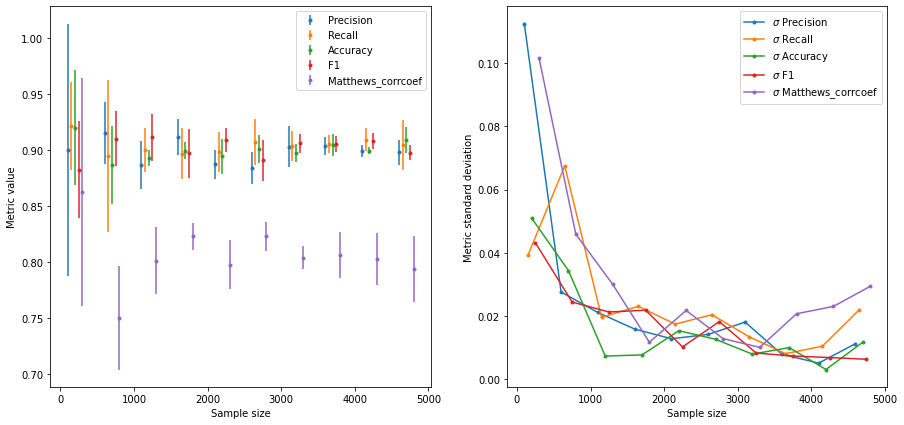

In [11]:
%%time
def evaluate_metrics_with_cross_validation(nEvents, metric_name):
    df_train = df.sample(nEvents)
    value = cross_val_score(model, df_train[["x","y"]], df_train["label"], cv=5, scoring=metric_name)
    return np.array([value.mean(), value.std()])


_, axes = plt.subplots(1, 2, figsize=(15, 7))

metric_names = ['precision','recall','accuracy','f1',"matthews_corrcoef"]
sampleSizes = np.arange(100,5000,500)
for metric_index, metric_name in enumerate(metric_names):
    scores = np.array([evaluate_metrics_with_cross_validation(nEvents, metric_name) for nEvents in sampleSizes])
    axes[0].errorbar(sampleSizes+50*metric_index, scores[:,0], linestyle="None", yerr = scores[:,1], marker=".",label = metric_name.capitalize());
    axes[1].plot(sampleSizes+50*metric_index, scores[:,1], marker=".",label = r"$\sigma$ "+metric_name.capitalize());

axes[0].set_xlabel("Sample size")
axes[0].set_ylabel("Metric value")
axes[0].legend();

axes[1].set_xlabel("Sample size")
axes[1].set_ylabel("Metric standard deviation")
axes[1].legend();

# Przypadek klas niezrównoważonych.

Do tej pory liczebność obu klas w analizowanych danych była równa. Teraz to zmienimy.

**Proszę:**

* korzystając z początkowych zbiorów `class_0_data` oraz `class_1_data` stworzyć zbiór w którym klasy nie bedą równoliczne i klasa "1" jest 100 razy bardziej liczba niż klasa "0".

**Wskazówka**: 

stwórz nowy obiekt DataFrame z danych dla klas "0" i "1", ale dobierz próbkowanie danych dla poszczególnych klas, tak by w sumarycznym zbiorze klasa "1" była 100 razy bardziej liczba niż klasa "0".

In [12]:
#BEGIN_SOLUTION
df_non_equal = pd.concat([df_class_0.sample(frac=0.01), df_class_1], ignore_index=True)
#END_SOLUTION
print(df_non_equal)

              x         y  label
0     -0.933196  2.607594    0.0
1     -1.990850  2.129540    0.0
2      1.750780  2.303596    0.0
3      0.481096 -1.143794    0.0
4     -1.811539  3.112470    0.0
...         ...       ...    ...
10095  0.003325  5.481831    1.0
10096  0.511613  5.006285    1.0
10097  0.061549  2.833663    1.0
10098  1.515413  5.558962    1.0
10099  5.110123  4.439844    1.0

[10100 rows x 3 columns]


**Proszę:**

Korzystając z metod klasy DataFrame:
* narysować rozkłady wszystkich zmiennych wejściowych oddzielnie dla klas 0 i 1
* narysować wykres korelacji między zmiennymi wejściowymi oddzielnie dla klas 0 i 1

**Wskazówka**: 
* proszę użyć filtrowania obiektu DataFrame
* proszę użyć parametru "hue" funkcji ```sns.jointplot()```

Oglądając rysunki proszę sprawdzić jakościowo:
* czy krotności klas są zgodne z założeniami?

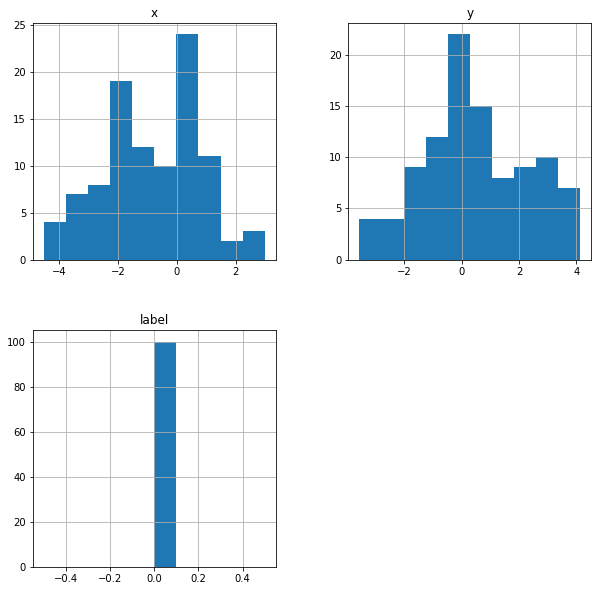

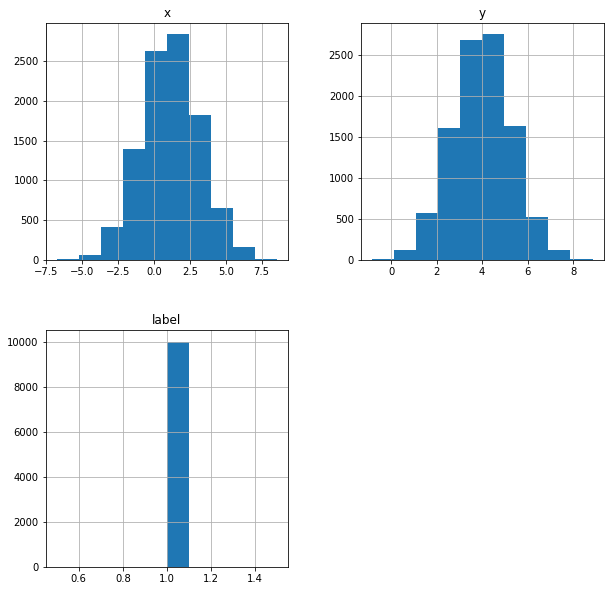

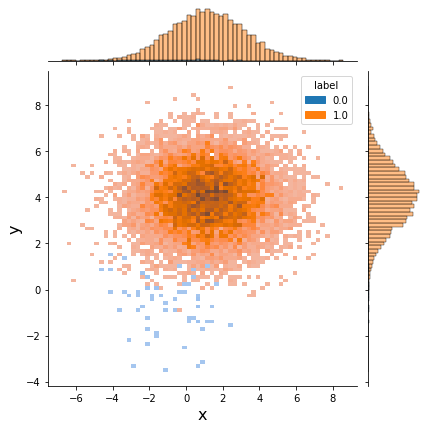

In [13]:
#Histogramy rozkładów dla klasy "0"
#BEGIN_SOLUTION
df_non_equal[df_non_equal["label"]==0].hist(figsize=(10,10))
#END_SOLUTION

#Histogramy rozkładów dla klasy "1"
#BEGIN_SOLUTION
df_non_equal[df_non_equal["label"]==1].hist(figsize=(10,10))
#END_SOLUTION

#Dwuwymiarowy rozkład y vs x dla klasy "0" i 1"
#BEGIN_SOLUTION
x = sns.jointplot(x="x", y="y", data=df_non_equal, kind='hist', hue="label")
x.set_axis_labels('x', 'y', fontsize=16);
#END_SOLUTION
##

**Proszę:**

* korzystając z funkcji ```plot_ROC(data)``` wypisz na ekran wartości miar, oraz narysuje krzywe ROC dla danych niezrównoważonych.

Fold number: 0
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.49 +/- 0.27
Fold number: 1
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.67 +/- 0.13
Fold number: 2
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.42 +/- 0.35
Fold number: 3
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.80 +/- 0.08
Fold number: 4
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.59 +/- 0.14


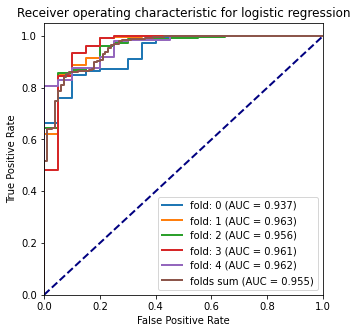

In [14]:
#BEGIN_SOLUTION
plot_ROC(data=df_non_equal) 
#END_SOLUTION
##

# Zadanie domowe

Proszę przeprowadzić analogiczną analizę: wypisać wartości metryk i narysować krzywe ROC dla danych w których rozkłady klas wyraźnie się różnią, 
oraz dla takich które się pokrywają. W każdym przypadku niech klasa "1" będzie 100 razy bardziej liczna niż klasa "0"

**Proszę:** 

* kiedy rozkłady (x,y) dla klas "0" i "1" takie same - klasy są trudno nie rozróżnialne:
   
   średnie i wariancje zmiennych $x$ i $y$ dla obu klas są takie same
  
  
* kiedy rozkłady (x,y) dla klas "0" i "1" są bardzo rózne - klasa są łatwo separowalne: 
   
  średnie zmiennych $x$ i $y$ dla obu klas różnią się o wartość 3, wariancje są takie same i wynoszą `

***
Przypadek klas nie rozróżnialnych.

class_0_data.shape  (10000, 3)
class_1_data.shape  (10000, 3)
Fold number: 0
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.00 +/- 0.00
Fold number: 1
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.00 +/- 0.00
Fold number: 2
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.00 +/- 0.00
Fold number: 3
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.00 +/- 0.00
Fold number: 4
Precision = 0.99 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 0.99 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.00 +/- 0.00


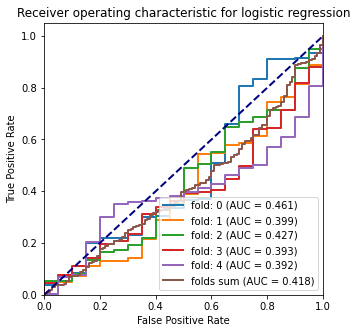

In [15]:
nPoints = 10000    
#BEGIN_SOLUTION    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
means_class_1 = np.array([0,0]) 
covariance_class_1 = np.diag([1,1]) 

#Definicja parametrów rozkładu Gaussa dla klasy "1"
means_class_2 = np.array([0,0]) 
covariance_class_2 = np.diag([1,1]) 

#Generacja danych dla klas "0" i "1"
class_0_data = generate_class_data(nPoints, means_class_1, covariance_class_1, label=0)
class_1_data = generate_class_data(nPoints, means_class_2, covariance_class_2, label=1)

#Sprawdzenie czy wygenrowane dane mają poprawny kształt
print("class_0_data.shape ",class_0_data.shape)
print("class_1_data.shape ",class_1_data.shape)

#Utworzenie obiektu DataFrame dla klas "0" i "1"
df_class_0 = pd.DataFrame(data=class_0_data, columns = ["x", "y", "label"])
df_class_1 = pd.DataFrame(data=class_1_data, columns = ["x", "y", "label"])

#Utworzenie obiektu DataFrame dla odu klas lącznie
df_similar_classes = pd.concat([df_class_0.sample(frac=0.01), df_class_1], ignore_index=True)

y_pred = model.predict_proba(df_similar_classes[["x","y"]])

#Wyrysowanie krzywej ROC
plot_ROC(data=df_similar_classes, assignAllToClass1=False) 

#END_SOLUTION
##

***
Przypadek gdy klasy są łatwo odróżnialne:

class_0_data.shape  (10000, 3)
class_1_data.shape  (10000, 3)
Fold number: 0
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.95 +/- 0.07
Fold number: 1
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.86 +/- 0.00
Fold number: 2
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.87 +/- 0.09
Fold number: 3
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.84 +/- 0.10
Fold number: 4
Precision = 1.00 +/- 0.00
Recall = 1.00 +/- 0.00
Accuracy = 1.00 +/- 0.00
F1 = 1.00 +/- 0.00
Matthews_corrcoef = 0.79 +/- 0.17


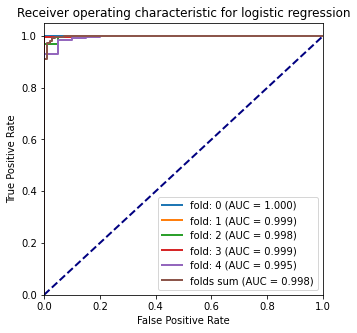

In [16]:
nPoints = 10000    
#BEGIN_SOLUTION    
#Defincja parametrów rozkładu Gaussa dla klasy "0"    
means_class_1 = np.array([0,0]) 
covariance_class_1 = np.diag([1,1]) 

#Definicja parametrów rozkładu Gaussa dla klasy "1"
means_class_2 = np.array([3,3]) 
covariance_class_2 = np.diag([1,1]) 

#Generacja danych dla klas "0" i "1"
class_0_data = generate_class_data(nPoints, means_class_1, covariance_class_1, label=0)
class_1_data = generate_class_data(nPoints, means_class_2, covariance_class_2, label=1)

#Sprawdzenie czy wygenrowane dane mają poprawny kształt
print("class_0_data.shape ",class_0_data.shape)
print("class_1_data.shape ",class_1_data.shape)

#Utworzenie obiektu DataFrame dla klas "0" i "1"
df_class_0 = pd.DataFrame(data=class_0_data, columns = ["x", "y", "label"])
df_class_1 = pd.DataFrame(data=class_1_data, columns = ["x", "y", "label"])

#Utworzenie obiektu DataFrame dla odu klas lącznie
df_separated_classes = pd.concat([df_class_0.sample(frac=0.01), df_class_1], ignore_index=True)

#Wyrysowanie krzywej ROC
plot_ROC(data=df_separated_classes, assignAllToClass1=False) 

#END_SOLUTION
##

# Wnioski:

1) Jak się zachowuje model w sytuacji dużej różnicy częstości występowania dwóch klas?

#BEGIN_SOLUTION

Model ma tendencję do przypisywania wszystkich przypadków do dominującej klasy. Wskazuje na to wartość "Precision" i "Recall" bliska 100% pomimo tego, że 
krzywa ROC jest bliska diagonalnej.

#END_SOLUTION

2) Jak zachowują się różne metryki w sytuacji dużej różnicy częstości występowania dwóch klas?

#BEGIN_SOLUTION

Metryki oparte jedynie na ułamku poprawnych/błędnych klasyfikacji są bardzo podatne nie nierownowagę klas.

#END_SOLUTION

3) Jak można przeciwdziałać efektowi częstości występowania?

#BEGIN_SOLUTION

* zebranie większej ilości danych
* przeważanie przykładów prowadzące do równoważenia danych
* analiza modeli z użyciem metryk mniej podatnych nie nierównowagę klas: MCC, ROC, macierz pomyłek

#END_SOLUTION

4) Czy efekt częstości występowania ma taki sam czy różny wpływ na miary jakości w przypadku, gdy klasy pochodzą z rozkładów, które się znacząco pokrywają lub są mocno rozseparowane?

#BEGIN_SOLUTION

W przypadku klas łatwo separowalnych proste modele są w stanie je odróżnić, nawet w sytuacji dużej nierównowagi. 

#END_SOLUTION
##